In [1]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [2]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

<span style="color:#13213b;">[Andrii Gakhov](https://www.gakhov.com) / PyCon UA 2018</span>
* * *
## An Introduction to Time Series Forecasting with Python
Time series is an important instrument to model, analyze and predict data collected over time. In this talk, we learn the basic theoretical concepts without going deep into mathematical aspects, study different models, and try them in practice using StatsModels, Prophet, scikit-learn, and keras.

# Part 3. Aritificial Neural Networks
******

### OS visits to UK (All visits) 
The dataset represents the monthly total number of visits to the UK by overseas residents (in thousands)<br>from January 1980 to October 2017. 

#### Source: [Office for National Statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/timeseries/gmaa/ott)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Seasonal ANN with LSTM unit
----

### Load the data into Pandas DataFrame

In [5]:
import pandas as pd
df = pd.read_csv("data/GMAA-040218.csv", header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value = df.value.astype(int)

In [6]:
import numpy as np
np.random.seed(seed=42)

train_range = df[df.period < '2010-01-01'].index
validate_range = df[(df.period >= '2010-01-01') & (df.period < '2014-01-01')].index
test_range = df[(df.period >= '2014-01-01') & (df.period < '2017-01-01')].index

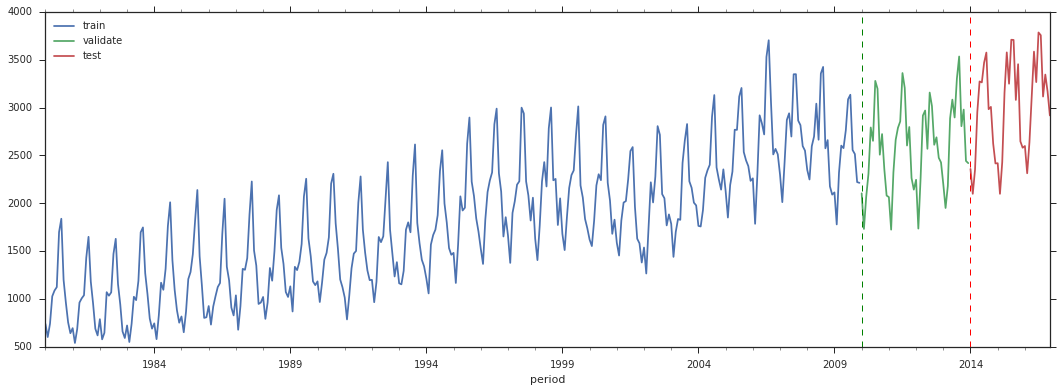

In [7]:
fig, ax = plt.subplots(figsize=(18,6))
df.loc[train_range].plot(x="period", y="value", ax=ax, label="train")
df.loc[validate_range].plot(x="period", y="value", ax=ax, label="validate")
df.loc[test_range].plot(x="period", y="value", ax=ax, label="test")

ax.axvline(pd.to_datetime(str(df.loc[validate_range].period.values[0])), c='green', ls='--', lw=1)
plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('images/ann-split.png');

### Prepare data for ANN model

While working with artificial network, it's always a good idea to properly scale your data.

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df.value.astype(float).values.reshape(-1, 1));

### Convert observations into the seasonal learning data

Instead of directly leaning the number of visitors by the observation date, we will learn values in the next season based on the values in the previous one.

#### Thus, for new learning data we take vectors $x = [t - seasons, t)$, while the expected values are vectors $y = [t, t+ seasons)$.

In [9]:
def build_seasonal_learning_sequences(data, indices, seasons=12):
    train, validate, test = indices
    
    X_train = np.empty(shape=(0, seasons))
    y_train = np.empty(shape=(0, seasons))
    
    X_val = np.empty(shape=(0, seasons))
    y_val = np.empty(shape=(0, seasons))
    
    X_test = np.empty(shape=(0, seasons))
    y_test = np.empty(shape=(0, seasons))
    
    for i in range(seasons, data.shape[0] - seasons):
        X = data[i - seasons:i].reshape(1,-1)
        y = data[i:i + seasons].reshape(1,-1)
        if i in train:
            X_train = np.concatenate((X_train, X), axis=0)
            y_train = np.concatenate((y_train, y), axis=0)
        elif i in validate:
            X_val = np.concatenate((X_val, X), axis=0)
            y_val = np.concatenate((y_val, y), axis=0)
        elif i in test:
            X_test = np.concatenate((X_test, X), axis=0)
            y_test = np.concatenate((y_test, y), axis=0)

    return X_train, y_train, X_val, y_val, X_test, y_test

#### For our data we observe the yearly seasonality, thus we select $seasons=12$

In [10]:
seasons = 12
indices = [train_range, validate_range, test_range]

X_train, y_train, X_val, y_val, X_test, y_test = build_seasonal_learning_sequences(
    data, indices, seasons)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## ANN model with keras

#### keras already supports the evaluation of metrics during the training, and already have MAE / MSE built-in support. We can create additionally $R^2$ and $Theil's U$ metrics.

In [12]:
from keras import backend as K

def r2_metric(y_true, y_pred):
    """Calculate R^2 statistics using observed and predicted tensors."""
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))


def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted tensors."""
    SS_res =  K.mean(K.square(y_true - y_pred))
    SS_true = K.mean(K.square(y_true))
    SS_pred = K.mean(K.square(y_pred))
    
    return K.sqrt(SS_res / (SS_true * SS_pred))

Using TensorFlow backend.


#### The main problem while working with ANNs is the choice of the network's parameters, such as number of layers and number of  neurons.

#### Hopefully, the researches in this field (see C. Hamzacebi) already came up with some recommendations:

* only 1 hidden layer
* number of input and output neurons can be taken as number of observations in a season
* number of hidden nodes should be detemined experimentally (but usually, a few is enough)

In [13]:
from keras.layers import InputLayer, Dense, LSTM
from keras.models import Sequential
from keras.optimizers import SGD

sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=False)

model = Sequential()
model.add(InputLayer(input_shape=(1, seasons), name="input"))
model.add(LSTM(4, name="hidden", activation='sigmoid', use_bias = True, bias_initializer='ones'))
model.add(Dense(seasons, name="output", activation='linear', use_bias = True, bias_initializer='ones'))
model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=["mae", "mse", r2_metric, theils_u_metric])

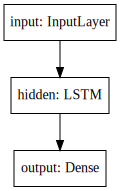

In [14]:
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='images/ann-model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### Fit the model

In [15]:
num_of_epochs = 40
history = model.fit(
    X_train, y_train,
    epochs=num_of_epochs,
    batch_size=1,
    verbose=0,
    validation_data=(X_val, y_val));

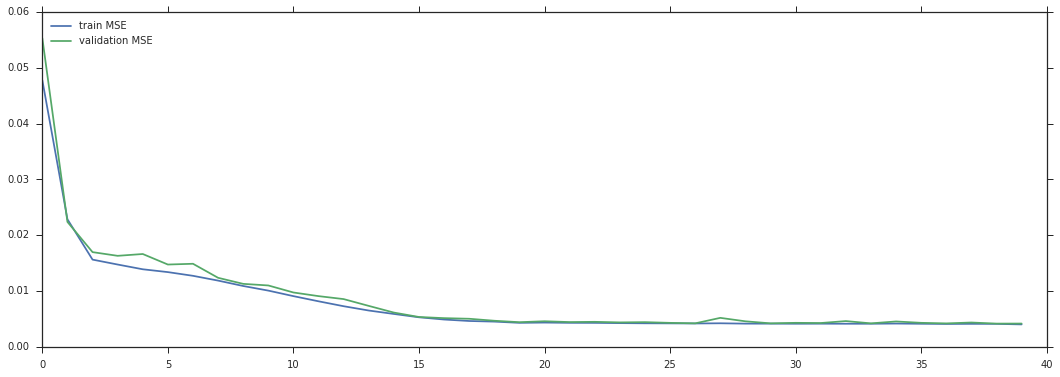

In [16]:
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(history.history["mean_squared_error"], label="train MSE")
plt.plot(history.history["val_mean_squared_error"], label="validation MSE")
plt.legend(loc='upper left')
plt.savefig('images/ann-val-history.png');

### Evaluate the model

In [17]:
_, mae, mse, r2, u = model.evaluate(X_train, y_train, batch_size=1, verbose=0)

print("MAE (train): {:0.3f}".format(mae))
print("MSE (train): {:0.3f}".format(mse))
print("R2  (train): {:0.3f}".format(r2))
print("U   (train): {:0.3f}".format(u))

MAE (train): 0.052
MSE (train): 0.004
R2  (train): 0.700
U   (train): 0.601


In [18]:
_, mae, mse, r2, u = model.evaluate(X_val, y_val, batch_size=1, verbose=0)

print("MAE (val): {:0.3f}".format(mae))
print("MSE (val): {:0.3f}".format(mse))
print("R2  (val): {:0.3f}".format(r2))
print("U   (val): {:0.3f}".format(u))

MAE (val): 0.053
MSE (val): 0.004
R2  (val): 0.730
U   (val): 0.169


### Forecast

In [19]:
yhat_train = model.predict(X_train[::seasons])
yhat_val = model.predict(X_val[::seasons])
yhat_test = model.predict(X_test[::seasons])

yhat_train_unscaled = scaler.inverse_transform(yhat_train).flatten()
yhat_val_unscaled = scaler.inverse_transform(yhat_val).flatten()
yhat_test_unscaled = scaler.inverse_transform(yhat_test).flatten()

In [20]:
y_train_unscaled = scaler.inverse_transform(y_train[::seasons]).flatten()
y_val_unscaled = scaler.inverse_transform(y_val[::seasons]).flatten()
y_test_unscaled = scaler.inverse_transform(y_test[::seasons]).flatten()

### Evaluate the forecast

In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

mae = mean_absolute_error(y_test_unscaled, yhat_test_unscaled)
mse = mean_squared_error(y_test_unscaled, yhat_test_unscaled)
r2 = r2_score(y_test_unscaled, yhat_test_unscaled)
u = theils_u_metric(y_test_unscaled, yhat_test_unscaled)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

MAE (test): 248
MSE (test): 89043
R2  (test): 0.635
U   (test): 0.000034


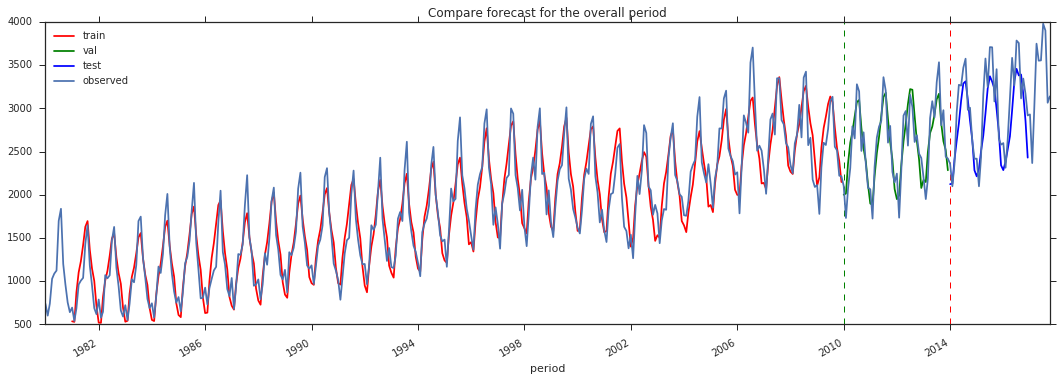

In [22]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[train_range].period.values)[seasons:], yhat_train_unscaled,
        color="red", label="train")
ax.plot(pd.to_datetime(df.loc[validate_range].period.values), yhat_val_unscaled,
        color="green", label="val")
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test_unscaled,
        color="blue", label="test")

ax.axvline(pd.to_datetime(str(df.loc[validate_range].period.values[0])), c='green', ls='--', lw=1)
plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the overall period')

plt.savefig('images/ann-compare-forecast-overall.png')
plt.show();

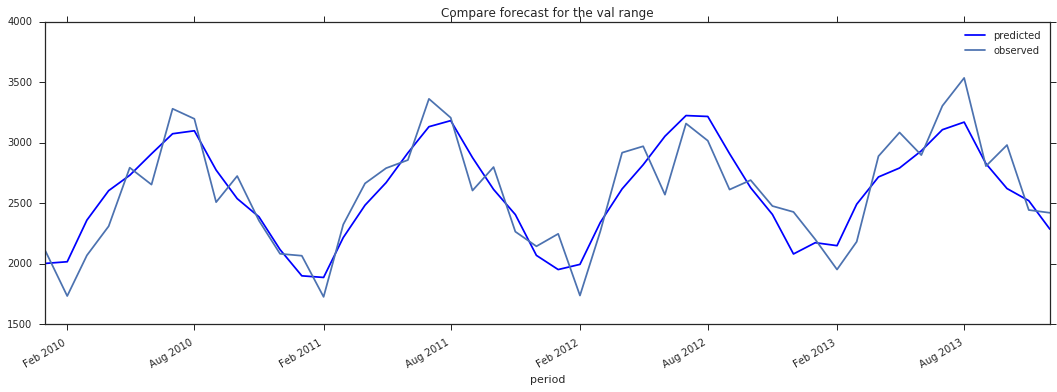

In [23]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[validate_range].period.values), yhat_val_unscaled,
        color="blue", label="predicted")

df.loc[validate_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the val range')

plt.savefig('images/ann-compare-forecast-valrange.png')
plt.show();

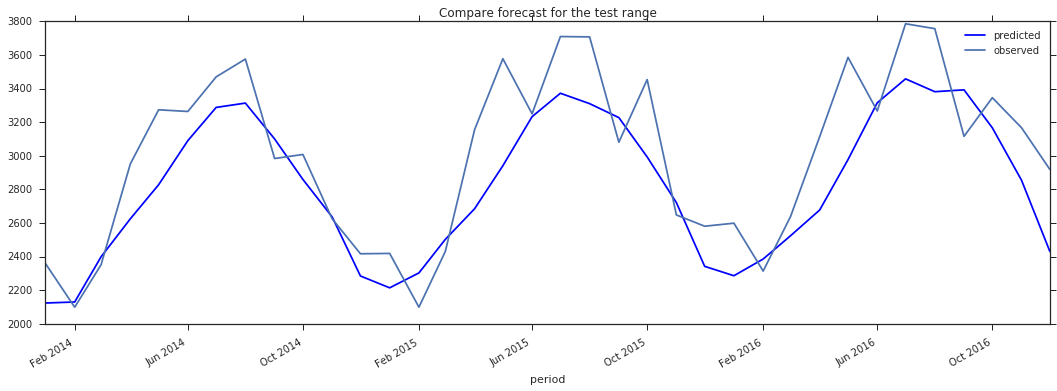

In [24]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test_unscaled,
        color="blue", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range')

plt.savefig('images/ann-compare-forecast-testrange.png')
plt.show();